# The Battle of Neighborhoods in Nashville: Opening a New Pet Store

### Introduction/Business Problem
The American Pet Products Association (APPA) estimates that within the year, $75.38 billion will be spent on pets in the United States alone. The pet services market, which includes grooming, boarding, training, and care has been the fastest-growing product segment under the industry umbrella. As such, an eCommerce-based Pet retailer has decided to open their first brick and mortar store in the Nashville metro area as part of their new business strategy.

The retailer has invested funding for a deep dive into location data analysis to determine which neighborhood in Nashville would be the most suitable for the new store. As the retailer is leaning into the pet services market, they feel that their best strategy is to seek a location in higher density areas where consumers typically frequent for shopping and entertainment. This analysis will include Foursquare location data, where we will dig deeper into locations with a high frequency of restaurants and grocery stores, as well as look into locations of other pet stores to avoid opening too close to a competitor. We will utilize these tools to make data-driven decisions about these neighborhoods.

### Data  
As stated in the introduction, listed below are the characteristics of a neighborhood that will influence the location chosen:

   * The frequency of existing restaurants in the neighborhood
   * The frequency of existing grocery stores in the neighborhood
   * Any nearby pet stores, which would be competition

We will use the below data sources to extract, generate, and analyze the required information:

   * List of all neighborhoods in the Nashville metro area, and their corresponding ZIP Codes and coordinates
       * Source: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=TN – Includes ZIP codes, city, state, and coordinate data
       * Source: https://nestinginnashville.com/buying-a-home-in-nashville/zip-code-map/ - Includes Nashville neighborhood names and ZIP codes
   * Frequency of restaurants, grocery stores, and pet stores in each neighborhood (Foursquare API)
   * Coordinates of all venues (GeoPy Nominatim)

#### Let's first import the required libraries to perform the analysis

In [40]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Now, let's import the necessary data and clean it up into a usable dataframe

In [2]:
# load the dataset and read it into a pandas dataframe.
# original data downloaded from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=TN

tn_data = pd.read_csv('https://raw.githubusercontent.com/karlyrezac/Coursera_Capstone/master/us-zip-code-latitude-and-longitude.csv')
tn_data.head()

,Zip Code,City,State,Latitude,Longitude
0,38401,Columbia,TN,35.619784,-87.03565
1,38017,Collierville,TN,35.057224,-89.67417
2,37616,Afton,TN,36.218863,-82.74704
3,38138,Germantown,TN,35.088885,-89.80677
4,37407,Chattanooga,TN,35.000825,-85.28673


In [3]:
# clean up the dataset to remove unnecessary State column

tn_data.drop(['State'], axis=1, inplace=True)
tn_data.head()

,Zip Code,City,Latitude,Longitude
0,38401,Columbia,35.619784,-87.03565
1,38017,Collierville,35.057224,-89.67417
2,37616,Afton,36.218863,-82.74704
3,38138,Germantown,35.088885,-89.80677
4,37407,Chattanooga,35.000825,-85.28673


In [4]:
# filter out rows outside of the city of Nashville

tn_data.drop(tn_data[tn_data.City != 'Nashville'].index, inplace = True)
tn_data.reset_index(drop = True, inplace = True)

tn_data.head()

,Zip Code,City,Latitude,Longitude
0,37217,Nashville,36.103408,-86.666160
1,37245,Nashville,36.186605,-86.785248
2,37238,Nashville,36.186605,-86.785248
3,37224,Nashville,36.186605,-86.785248
4,37205,Nashville,36.113558,-86.862070


#### Here, we'll join the table with neighborhood name dataset

In [5]:
# load neighborhoods dataset and read it into a pandas dataframe.
# original data downloaded from https://nestinginnashville.com/buying-a-home-in-nashville/zip-code-map/

neighborhood_data = pd.read_csv('https://raw.githubusercontent.com/karlyrezac/Coursera_Capstone/master/nash_neighborhoods.csv')
neighborhood_data.head()

,Zip Code,Neighborhood
0,37013,Antioch / Cane Ridge
1,37027,Brentwood
2,37072,Goodlettsville
3,37076,Hermitage
4,37115,Madison


In [6]:
# join dataframes

neighborhood_data['Zip Code'] = neighborhood_data['Zip Code'].astype(int)
nash_merged = pd.merge(tn_data, neighborhood_data, on='Zip Code')
tn_data = nash_merged[['Zip Code', 'City', 'Neighborhood', 'Latitude', 'Longitude']]
tn_data.head(12)

,Zip Code,City,Neighborhood,Latitude,Longitude
0,37217,Nashville,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616
1,37205,Nashville,Belle Meade / West Meade / West Nashville,36.113558,-86.86207
2,37204,Nashville,12 South / Belmont / Lipscomb / Green Hills / ...,36.112058,-86.77626
3,37208,Nashville,Germantown / TSU,36.174806,-86.80252
4,37211,Nashville,South Nashville/ Whispering Hills / Brentioch ...,36.079259,-86.72584
5,37207,Nashville,North Nashville / Dickerson Pike,36.215535,-86.77317
6,37201,Nashville,Downtown Riverfront / SoBro,36.164556,-86.77738
7,37203,Nashville,Music Row / Edgehill / Vandy / West End Circle...,36.152607,-86.78927
8,37221,Nashville,Bellevue,36.065032,-86.94674
9,37212,Nashville,Music Row / Vanderbilt / Hillsboro Village / B...,36.133251,-86.80057


#### Now let's use the .shape method to see number of rows in the dataframe

In [7]:
tn_data.shape

(19, 5)

### Neighborhood Candidates

We have located and imported the relevant data for the neighborhoods in Nashville, and have constructed a dataframe. Next, let's utilize GeoPy Nominatim to obtain coordinates, Foursquare location data to discover the neighborhoods where consumers typically frequent for shopping and entertainment, and the Folium library to visualize neighborhoods on a map.

#### Use GeoPy Nominatim to get the latitude and longitude values of Nashville

In [8]:
# get coordinates for Nashville
address = 'Nashville, TN'

# define the user_agent as nashville_explorer
geolocator = Nominatim(user_agent="nashville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Nashville are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Nashville are 36.1622296, -86.7743531.


#### From here, we'll leverage Folium to create a map of Nashville with neighborhoods superimposed on top

In [9]:
# create map of Nashville using latitude and longitude values
map_nashville = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(tn_data['Latitude'], tn_data['Longitude'], tn_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='teal',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_nashville)  
    
map_nashville

#### Now that we've pulled in and visualised the neighborhood candidates, let's use the Foursquare API to get information on restaurants and grocery stores in each neighborhood.

We will include only venues that have 'restaurant' or 'grocery store' in the category name. Let's also include venues listed as 'pet store', in order to eliminate some neighborhoods with competition.

Note: Foursquare credentials are defined in the below cell.

In [10]:
# define Foursquare credentials and version
CLIENT_ID = '[hidden for sharing]' # your Foursquare ID
CLIENT_SECRET = '[hidden for sharing]' # your Foursquare Secret
VERSION = '20200416' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Here, we'll explore one of the neighborhoods in a dataframe

In [11]:
tn_data.loc[2, 'Neighborhood']

'12 South / Belmont / Lipscomb / Green Hills / Oak Hill / Edgehill'

#### Let's first get the neighborhood's latitude and longitude values.

In [12]:
neighborhood_latitude = tn_data.loc[2, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = tn_data.loc[2, 'Longitude'] # neighborhood longitude value

neighborhood_name = tn_data.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 12 South / Belmont / Lipscomb / Green Hills / Oak Hill / Edgehill are 36.112058000000005, -86.77626.


#### Now, we'll retrieve the top 50 venues that are in this neighborhood within a radius of 1000 meters.

In [13]:
LIMIT = 50 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YMUL3HU2WHW12ZPQTAS4VIGTD2S0FYZLBRPIT5PN4ZX4ZOWS&client_secret=CECEBTYIOD214WSZKIFAI5S0UVNKL333OXHJOJPFS2S0BRN1&v=20200416&ll=36.112058000000005,-86.77626&radius=1000&limit=50'

#### Let's take a look at the results

In [14]:
# send the GET request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea5d9521d67cb656ac70df2'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Nashville',
  'headerFullLocation': 'Nashville',
  'headerLocationGranularity': 'city',
  'totalResults': 44,
  'suggestedBounds': {'ne': {'lat': 36.121058009000016,
    'lng': -86.76514032617438},
   'sw': {'lat': 36.10305799099999, 'lng': -86.78737967382561}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c057d86517d0f477d9df415',
       'name': 'Thai Kitchen',
       'location': {'address': '738 Thompson Ln',
        'lat': 36.112590353985304,
        'lng': -86.76802751823402,
        'labeledLatLngs': [{'label': 'display',


In [15]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Next, we need to clean the json and structure it into a pandas dataframe.

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Thai Kitchen,Thai Restaurant,36.112590,-86.768028
1,Sunflower Café,Vegetarian / Vegan Restaurant,36.113292,-86.767803
2,Yellow Porch,Wine Bar,36.112609,-86.767692
3,Merengue Cafe,Cuban Restaurant,36.113563,-86.768337
4,Vui's Kitchen,Vietnamese Restaurant,36.113060,-86.766609
5,Baja Burrito,Burrito Place,36.112479,-86.766162
6,Sam & Zoe's,Coffee Shop,36.112687,-86.766281
7,The Juice Bar,Juice Bar,36.113156,-86.766432
8,Blackbird Studio,Music Venue,36.116041,-86.767488
9,Jersey Mike's Subs,Sandwich Place,36.112647,-86.767858


In [37]:
# check the number of venues returned by Foursquare

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


#### From here, we will create a nearby venues function for all the neighborhoods in Nashville

This will allow us to repeat the analysis we performed on the neighborhood above.


In [18]:
# create a function to repeat the same process to all the neighborhoods in Nashville

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### We'll run the above function on each neighborhood and create a new dataframe called *nash_venues*

In [19]:
nash_venues = getNearbyVenues(names=tn_data['Neighborhood'],
                                   latitudes=tn_data['Latitude'],
                                   longitudes=tn_data['Longitude']
                                  )

Edge-O-Lake / Priest Lake / Briley Parkway
Belle Meade / West Meade / West Nashville
12 South / Belmont / Lipscomb / Green Hills / Oak Hill / Edgehill
Germantown / TSU
South Nashville/ Whispering Hills / Brentioch / Lenox
North Nashville / Dickerson Pike
Downtown Riverfront / SoBro
Music Row / Edgehill / Vandy / West End Circle / Downtown (western) / The Gulch / Wedgewood Houston
Bellevue
Music Row / Vanderbilt / Hillsboro Village / Belmont
Inglewood
Sylvan Park / Sylvan Heights / The Nations / Charlotte Park
Downtown / Central Business District
Lower East Nashville / Lockeland Springs
Woodbine / Glencliff / Briley / Elm Hill
Green Hills / Forest Hills / Belle Meade
Bordeaux
Donelson / Airport
Oak Hill / Crieve Hall


In [38]:
# check size of dataframe

print(nash_venues.shape)
nash_venues.head()

(590, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616,SONIC Drive In,36.102494,-86.665977,Fast Food Restaurant
1,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616,Kobe Asian Restaurant,36.104618,-86.670860,Asian Restaurant
2,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616,Shell,36.103090,-86.666804,Gas Station
3,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616,Bus Stop 3,36.107244,-86.666389,Bus Station
4,Edge-O-Lake / Priest Lake / Briley Parkway,36.103408,-86.66616,Banjo's,36.104720,-86.671170,Restaurant


In [21]:
# check how many venues were returned for each neighborhood

nash_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
12 South / Belmont / Lipscomb / Green Hills / Oak Hill / Edgehill,44,44,44,44,44,44
Belle Meade / West Meade / West Nashville,4,4,4,4,4,4
Bellevue,8,8,8,8,8,8
Bordeaux,2,2,2,2,2,2
Donelson / Airport,38,38,38,38,38,38
Downtown / Central Business District,50,50,50,50,50,50
Downtown Riverfront / SoBro,50,50,50,50,50,50
Edge-O-Lake / Priest Lake / Briley Parkway,9,9,9,9,9,9
Germantown / TSU,27,27,27,27,27,27


In [22]:
# find out how many unique categories can be curated from the returned venues

print('There are {} unique categories.'.format(len(nash_venues['Venue Category'].unique())))

There are 171 unique categories.


### Methodology and Analysis

Let's perform some exploratory data analysis to draw in some additional information. Below, we will take the frequency of each venue category, and use that to list each neighborhood along with the top 5 most common venues.

In [23]:
# one hot encoding
nash_onehot = pd.get_dummies(nash_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nash_onehot['Neighborhood'] = nash_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nash_onehot.columns[-1]] + list(nash_onehot.columns[:-1])
nash_onehot = nash_onehot[fixed_columns]

nash_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Dosa Place,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Liquor Store,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Print Shop,Pub,Record Shop,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Edge-O-Lake / Priest Lake / Briley Parkway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Edge-O-Lake / Priest Lake / Briley Parkway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Edge-O-Lake / Priest Lake / Briley Parkway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Edge-O-Lake / Priest Lake / Briley Parkway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
# get new dataframe size

nash_onehot.shape

(590, 171)

In [25]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

nash_grouped = nash_onehot.groupby('Neighborhood').mean().reset_index()
nash_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Dosa Place,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Liquor Store,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Print Shop,Pub,Record Shop,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,12 South / Belmont / Lipscomb / Green Hills / ...,0.000000,0.000000,0.000000,0.00000,0.022727,0.000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00000,0.022727,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.068182,0.045455,0.000000,0.022727,0.000000,0.00,0.00,0.022727,0.000000,0.000000,0.00,0.022727,0.00,0.000000,0.00,0.022727,0.022727,0.022727,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000,0.00,0.00,0.068182,0.0,0.000000,0.00,0.00000,0.00,0.00,0.00,0.00,0.00,0.000000,0.022727,0.045455,0.000000,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.022727,0.000,0.000,0.022727,0.000000,0.00,0.000,0.022727,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.045455,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.022727,0.068182,0.022727,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.022727,0.045455,0.000000,0.000000,0.00,0.000,0.000000,0.022727,0.022727,0.000000,0.00,0.000000,0.000000,0.022727,0.022727,0.022727,0.000000,0.00,0.00,0.022727,0.00,0.022727,0.00,0.000000,0.000000,0.022727,0.000,0.022727,0.022727,0.00,0.022727,0.000000,0.022727,0.000000
1,Belle Meade / West Meade / West Nashville,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,

In [26]:
# confirm new size

nash_grouped.shape

(19, 171)

In [27]:
# print each neighborhood along with the top 5 most common venues

num_top_venues = 5
# nash_grouped['Neighborhood'] = int(nash_grouped['Neighborhood'])

for hood in nash_grouped['Neighborhood']:
    print("----"+str(hood)+"----")
    temp = nash_grouped[nash_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----12 South / Belmont / Lipscomb / Green Hills / Oak Hill / Edgehill----
                  venue  freq
0  Fast Food Restaurant  0.07
1              Pharmacy  0.07
2          Burger Joint  0.07
3           Music Venue  0.05
4         Burrito Place  0.05


----Belle Meade / West Meade / West Nashville----
            venue  freq
0    Home Service  0.25
1  Hardware Store  0.25
2   Moving Target  0.25
3          Museum  0.25
4     Music Venue  0.00


----Bellevue----
                venue  freq
0         Pizza Place  0.12
1        Intersection  0.12
2  Light Rail Station  0.12
3         Gas Station  0.12
4              Bakery  0.12


----Bordeaux----
                      venue  freq
0                      Park   1.0
1               Yoga Studio   0.0
2               Music Store   0.0
3  Mediterranean Restaurant   0.0
4               Men's Store   0.0


----Donelson / Airport----
                venue  freq
0         Pizza Place  0.13
1     Automotive Shop  0.08
2       Bowling Alley  0.05

#### Here, we will put the above into a *pandas* dataframe and sort venues in descending order

In [28]:
# sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's visualize the top 10 venue categories for each neighborhood

The below table can also be used as a helpful reference for the retailer and can provide a quick rundown of information for all of the neighborhoods in Nashville. While we're analyzing more granular data, we can still refer to this table for the top categories of venues in each of the neighborhoods.

In [39]:
# create the new dataframe and display the top 10 venues for each zip code

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nash_grouped['Neighborhood']

for ind in np.arange(nash_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nash_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,12 South / Belmont / Lipscomb / Green Hills / ...,Pharmacy,Burger Joint,Fast Food Restaurant,Gas Station,Sandwich Place,Music Venue,Burrito Place,Snack Place,Salon / Barbershop,Big Box Store
1,Belle Meade / West Meade / West Nashville,Hardware Store,Museum,Home Service,Moving Target,Farmers Market,Event Space,Dosa Place,Donut Shop,Dive Bar,Discount Store
2,Bellevue,Light Rail Station,Pizza Place,Golf Course,Trail,Gastropub,Gas Station,Bakery,Intersection,Dessert Shop,Farmers Market
3,Bordeaux,Park,Women's Store,Dessert Shop,Fast Food Restaurant,Farmers Market,Event Space,Dosa Place,Donut Shop,Dive Bar,Discount Store
4,Donelson / Airport,Pizza Place,Automotive Shop,Mexican Restaurant,Sandwich Place,Bowling Alley,Seafood Restaurant,Flower Shop,Fast Food Restaurant,Donut Shop,Discount Store
5,Downtown / Central Business District,Hotel,Music Venue,American Restaurant,Bar,Steakhouse,Sandwich Place,Mexican Restaurant,Concert Hall,Park,Pizza Place
6,Downtown Riverfront / SoBro,Bar,Music Venue,Hotel,Steakhouse,American Restaurant,Mexican Restaurant,Park,Concert Hall,Cocktail Bar,Sandwich Place
7,Edge-O-Lake / Priest Lake / Briley Parkway,Bus Station,Sporting Goods Shop,Convenience Store,Asian Restaurant,Restaurant,Gas Station,Fast Food Restaurant,Wine Shop,Diner,Farmers Market
8,Germantown / TSU,Pizza Place,Fried Chicken Joint,Smoothie Shop,Cosmetics Shop,Restaurant,Seafood Restaurant,Jewelry Store,Pub,Italian Restaurant,Intersection
9,Green Hills / Forest Hills / Belle Meade,Clothing Store,Mobile Phone Shop,Women's Store,Sandwich Place,American Restaurant,Bar,Cosmetics Shop,Coffee Shop,Burger Joint,Pub


#### Further analyzing the venue types criteria relevant to the location of a new pet store

Below, we will visualize the frequency of occurrence of venues for the neighborhoods in Nashville. Then, we will isolate the categorical venues. The ideal pet store locations will have a high density of grocery stores and restaurants, and a low density of other pet stores that may be competitors.

#### The below data shows a violin plot from the seaborn library, which visualizes a density estimation of the underlying distribution 

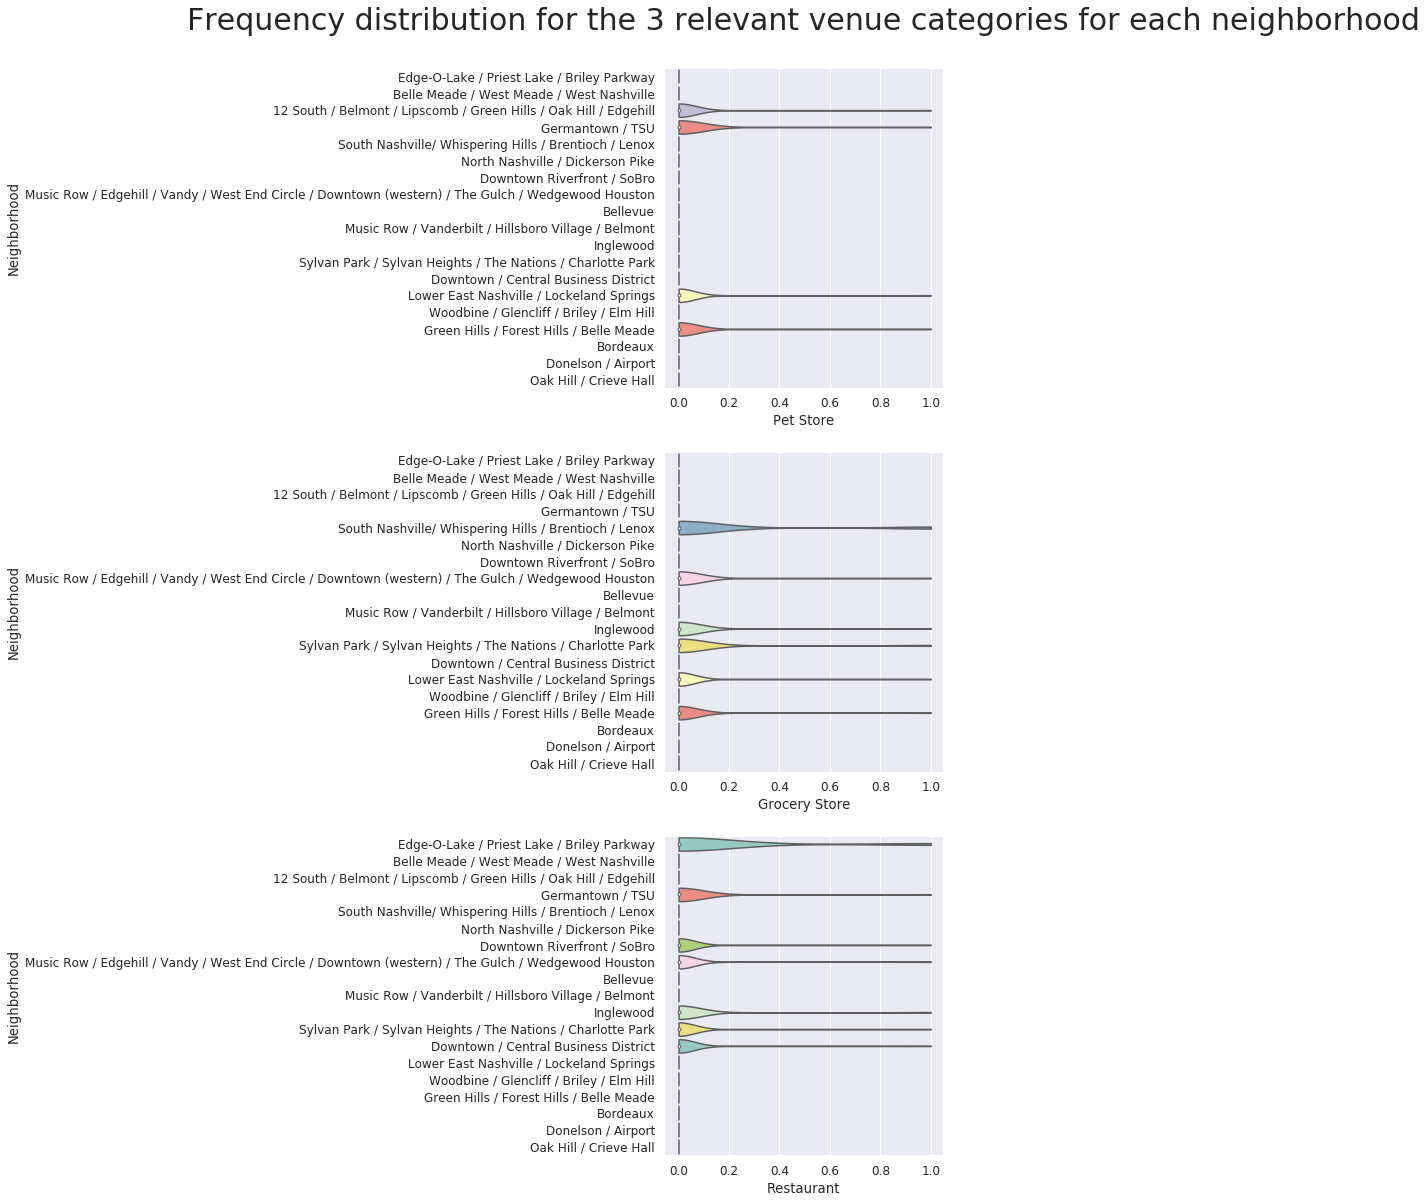

In [30]:
# plot the 3 relevant venue types: Pet Stores, Grocery Stores, and Restaurants

import seaborn as sns

fig = plt.figure(figsize=(5,20))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="Pet Store", y="Neighborhood", data=nash_onehot, cut=0, scale="width", palette="Set3");
plt.xlabel("Pet Store")

ax = plt.subplot(3,1,2)
sns.violinplot(x="Grocery Store", y="Neighborhood", data=nash_onehot, cut=0, scale="width", palette="Set3");
plt.xlabel("Grocery Store")

ax = plt.subplot(3,1,3)
sns.violinplot(x="Restaurant", y="Neighborhood", data=nash_onehot, cut=0, scale="width", palette="Set3");
plt.xlabel("Restaurant")

plt.title('Frequency distribution for the 3 relevant venue categories for each neighborhood', y=3.5, fontsize = 30)
plt.savefig ("Dist_Freq_Venues.png", dpi=240)
plt.show()

#### Narrowing down the neighborhoods

As shown in the above visualization, we can narrow down the neighborhoods based on the frequency of nearby venues such as grocery stores and restaurants, which the retailer specified as higher density areas where consumers typically frequent for shopping and entertainment. The visualization also shows neighborhoods with a greater frequency of pet stores, which would likely want to be avoided due to the competition.

Fortunately, none of the neighborhoods had a high frequency of pet stores that also had a high frequency of restaurants and grocery stores. This allows us to narrow down our neighborhoods to the three with high frequencies of both restaurants and grocery stores.

#### As such, we can narrow down the neighborhoods to:

   * Inglewood
   * Sylvan Park/Sylvan Heights/The Nations/Charlotte Park
   * Music Row/Edgehill/Vandy/West End Circle/Downtowm/The Gulch/Wedgewood Houston

#### Let's visualize the final neighborhoods on a map!

In [31]:
# initialize final list of lists 
data = [[37216, 'Inglewood', 36.213004, -86.72594],
            [37209, 'Sylvan Park/Sylvan Heights/The Nations/Charlotte Park', 36.151324, -86.8559],
            [37203, 'Music Row/Edgehill/Vandy/West End Circle/Downtown/The Gulch/Wedgewood Houston', 36.152607, -86.78927]] 
  
# Create the pandas DataFrame 
final_df = pd.DataFrame(data, columns = ['Zip Code', 'Neighborhood', 'Latitude', 'Longitude']) 
final_df 

,Zip Code,Neighborhood,Latitude,Longitude
0,37216,Inglewood,36.213004,-86.72594
1,37209,Sylvan Park/Sylvan Heights/The Nations/Charlot...,36.151324,-86.85590
2,37203,Music Row/Edgehill/Vandy/West End Circle/Downt...,36.152607,-86.78927


In [32]:
# Create a folium map of Nashville with the final 3 neighborhoods superimposed
map_final = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=55,
        popup=label,
        color='teal',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_final)  
    
map_final

### Results and Discussion
 
The result of this analysis is three neighborhoods in Nashville that contain a low frequency of pet stores, but high density of restaurants and grocery stores: Inglewood, Sylvan Park/Sylvan Heights/The Nations/Charlotte Park, and Music Row/Edgehill/Vandy/West End Circle/Downtown/The Gulch/Wedgewood Houston.

These three neighborhoods meet the criteria specified by the retailer. However, this does not necessarily mean that these neighborhoods are ideal locations for a new pet store. The purpose of this analysis is to narrow down potential neighborhoods based on the criteria provided. Realistically, it's possible that there are reasons for the low frequency of existing pet stores in those neighborhoods, which would rule them out regardless of the lack of competition in that area. This analysis should be a good starting point to guide the next part of the process for the retailer to finalize a store location.

### Conclusion

By calculating grocery store, restaurant, and pet store density distribution from Foursquare data, we were able to identify three neighborhoods that the retailer can investigate further. Realistically, this analysis could have been performed with many different methodologies and based on many different data sources. For this project, I wanted to stick to a straight-forward approach to narrowing down options for the retailer.

This analysis and recommendations have achieved the objective of narrowing down the best neighborhood options based on the available data. 
The final determination for the store location will be made by the retailer, using their own expertise in the pet industry, and taking into consideration additional factors such as characteristics of each neighborhood, pricing, economic variables, and others.